# Panchromatic Sharpening
_This notebook is part of the collection accompanying the talk "Analyzing Satellite Images With Python Scientific Stack" by Milos Miljkovic given at PyData NYC 2014. The content is BSD licensed._

Panchromatic sharpening is a radiometric transformation which uses a higher resolution panchromatic band to fuse it with lower resolution red-green-blue bands. In other words, spatial information in the high-resolution grayscale Band 8 and color information in the RGB color Bands 4, 3, and 2 is merged to create a high-resolution color image.

There are a few algorithms for sharpening: Brovey, IHS, PCA, Gram-Schmidt, simple mean, and weighted algorithms used on per satellite data sets.

## Brovey Algorithm
The Brovey algorithm is a transform which has the properties of conserving image resolution and slightly skewing the color balance by increasing the low and high ends in image histograms.

In [101]:
# To install watermark extension execute:
%install_ext https://raw.githubusercontent.com/HyperionAnalytics/watermark/master/watermark.py
# %load_ext watermark

UsageError: Line magic function `%install_ext` not found.


In [2]:
# %watermark -v -m -p numpy,scikit-image,matplotlib

UsageError: Line magic function `%watermark` not found.


In [1]:
cd /home/sramirez/data/LC08_L1TP_180032_20191003_20191018_01_T1

/home/sramirez/data/LC08_L1TP_180032_20191003_20191018_01_T1


In [2]:
import numpy as np
from skimage import io, transform, exposure
from matplotlib import pyplot as plt

In [3]:
%matplotlib inline

In [4]:
def read_band(n):
    """
    Load Landsat 8 band
    Input:
    n - integer in the range 1-11
    Output:
    img - 2D array of uint16 type
    """
    if n in range(1, 12):
        tif_list = !ls *.TIF
        band_name = 'B' + str(n) + '.TIF'
        img_idx = [idx for idx, band_string in enumerate(tif_list) if band_name in band_string]
        print(tif_list[img_idx[0]])
        img = io.imread(tif_list[img_idx[0]])
        return img
    else:
        print('Band number has to be in the range 1-11!')

In [46]:
b4 = read_band(4)
b3 = read_band(3) 
b2 = read_band(2)  
b8 = read_band(8)

LC08_L1TP_180032_20191003_20191018_01_T1_B4.TIF
LC08_L1TP_180032_20191003_20191018_01_T1_B3.TIF
LC08_L1TP_180032_20191003_20191018_01_T1_B2.TIF
LC08_L1TP_180032_20191003_20191018_01_T1_B8.TIF


In [8]:
b4.max(), b4.min()

(61587, 0)

In [11]:
b2.max()

65535.0

In [209]:
b3.shape

(7781, 7661)

In [47]:
b4.shape

(7781, 7661)

In [49]:
np.dstack((b4, b3, b2)).shape

(7781, 7661, 3)

In [9]:
height = 7081 # rows 
width = 7841 # columns
point1_coord_y = 3236 
point2_coord_x = height - 6038
point2_coord_y = 4162
point1_coord_x = height - 6516
img432_roi = np.dstack((b4, b3, b2))[point1_coord_x:point2_coord_x, point1_coord_y:point2_coord_y, :]

### Scale all the bands to 0 - 1 range.
We will use only a portion of the sample image to ease RAM requirements and make transform more apparent.

In [24]:
b4 = b4[point1_coord_x:point2_coord_x, point1_coord_y:point2_coord_y]
b3 = b3[point1_coord_x:point2_coord_x, point1_coord_y:point2_coord_y]
b2 = b2[point1_coord_x:point2_coord_x, point1_coord_y:point2_coord_y]
b8 = b8[(point1_coord_x*2):(point2_coord_x*2), (point1_coord_y*2):(point2_coord_y*2)]

In [25]:
b4 = b4/float(b4.max())
b3 = b3/float(b3.max())
b2 = b2/float(b2.max())
b8 = b8/float(b8.max())

### Rescale RGB color image to match the resolution of the pan band.

In [27]:
img432 = np.dstack((b4, b3, b2))
img432_2x = transform.rescale(img432, 2)

### Divide each of the up-sampled RGB bands by their sum and multiply by pan band to produce three high-resolution RGB channels.

In [38]:
m = np.sum(img432_2x, axis=2)
ps4 = b8*img432_2x[:, :, 0]/m
ps3 = b8*img432_2x[:, :, 1]/m
ps2 = b8*img432_2x[:, :, 2]/m
img432_ps = np.dstack((ps4, ps3, ps2))

/home/sramirez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  
/home/sramirez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sramirez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


In [39]:
inds = np.where(np.isnan(img432_ps))
img432_ps[inds] = 0 # TODO: fix this

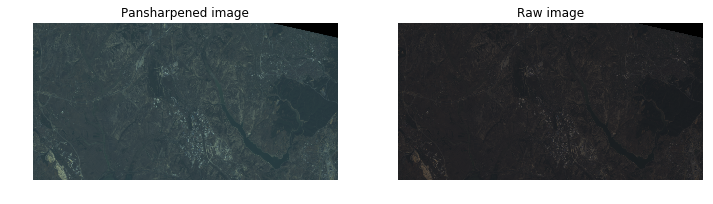

In [41]:
fig = plt.figure(figsize=(12, 9))
fig.set_facecolor('white')

ax1 = fig.add_subplot(121)
ax1.imshow(img432_2x)
plt.title('Pansharpened image')
plt.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(img432_roi/65535.0)
plt.title('Raw image')
plt.axis('off')

plt.show()

### Adjust image histograms

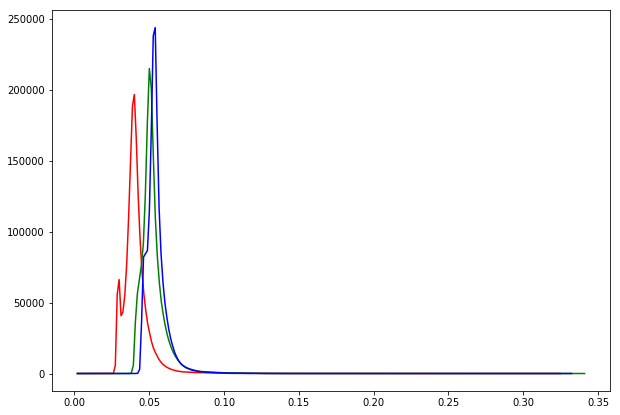

In [52]:
fig = plt.figure(figsize=(10, 7))
fig.set_facecolor('white')

for color, channel in zip('rgb', np.rollaxis(img432_ps, axis=-1)):
    counts, centers = exposure.histogram(channel)
    plt.plot(centers[1::], counts[1::], color=color)

plt.show()

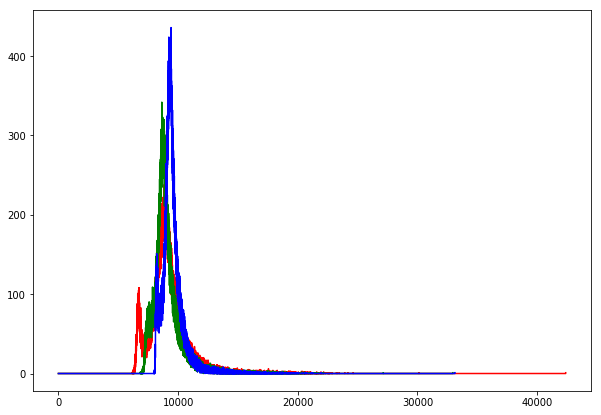

In [53]:
fig = plt.figure(figsize=(10, 7))
fig.set_facecolor('white')

for color, channel in zip('rgb', np.rollaxis(img432_roi, axis=-1)):
    counts, centers = exposure.histogram(channel)
    plt.plot(centers[1::], counts[1::], color=color)

plt.show()

In [54]:
img1 = np.empty(img432_ps.shape, dtype='float64')
lims = [(0.088,0.17), (0.108, 0.19), (0.130,0.20)]
for lim, channel in zip(lims, range(3)):
    img1[:, :, channel] = exposure.rescale_intensity(img432_ps[:, :, channel], lim)

In [55]:
img2 = np.empty(img432_roi.shape, dtype='float64')
lims = [(7100,14500), (8200, 14000), (9200,13500)]
for lim, channel in zip(lims, range(3)):
    img2[:, :, channel] = exposure.rescale_intensity(img432_roi[:, :, channel], lim)

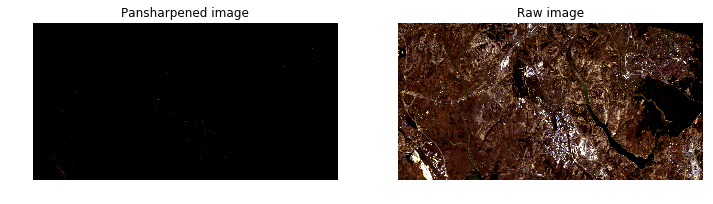

In [56]:
fig = plt.figure(figsize=(12, 9))
fig.set_facecolor('white')

ax1 = fig.add_subplot(121)
ax1.imshow(img1)
plt.title('Pansharpened image')
plt.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(img2/65535)
plt.title('Raw image')
plt.axis('off')

plt.show()

In [ ]:
from PIL import Image
img = Image.fromarray(np.uint8(img1))
img.save("test.TIF")

### Zoomed image region showing the result of pan-sharpening

In [ ]:
fig = plt.figure(figsize=(9, 12))
fig.set_facecolor('white')

ax1 = fig.add_subplot(121)
ax1.imshow(img1[750:1050, 880:1040, :])
plt.title('Pansharpened image - zoomed')
plt.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(img2[375:525, 440:520, :]/65535)
plt.title('Raw image - zoomed')
plt.axis('off')

plt.show()